In [54]:
#Torch import
import torch
from torch import nn
from torch.utils.data import random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader



import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from IPython.display import HTML

In [16]:
train_path = "data/train.csv"

In [17]:
test_path = "data/test.csv"

# EDA

In [18]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [19]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Remove unnecessary data

In [20]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Sample tweet

In [21]:
print(train_df[train_df["target"] == 0])

         id  keyword location  \
15       23      NaN      NaN   
16       24      NaN      NaN   
17       25      NaN      NaN   
18       26      NaN      NaN   
19       28      NaN      NaN   
...     ...      ...      ...   
7581  10833  wrecked  Lincoln   
7582  10834  wrecked      NaN   
7584  10837      NaN      NaN   
7587  10841      NaN      NaN   
7593  10848      NaN      NaN   

                                                   text  target  
15                                       What's up man?       0  
16                                        I love fruits       0  
17                                     Summer is lovely       0  
18                                    My car is so fast       0  
19                         What a goooooooaaaaaal!!!!!!       0  
...                                                 ...     ...  
7581  @engineshed Great atmosphere at the British Li...       0  
7582  Cramer: Iger's 3 words that wrecked Disney's s...       0  
7584  The

In [22]:
print(train_df[train_df["target"] == 1])

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

## Histogram

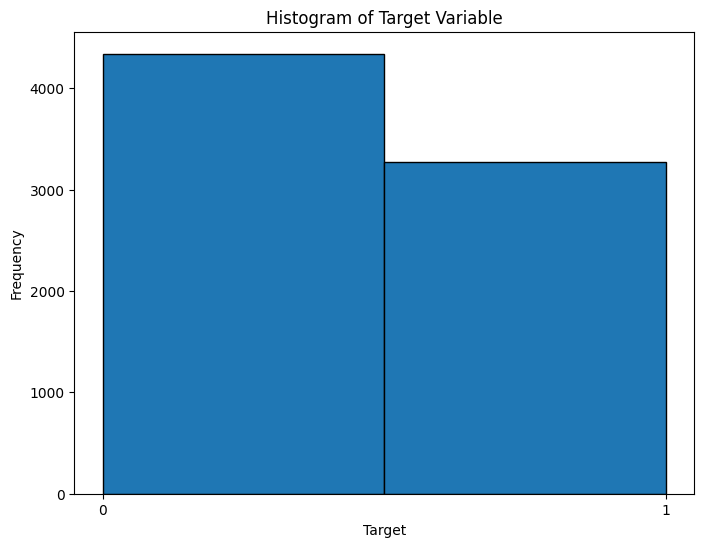

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(train_df['target'], bins=2, edgecolor='black')
plt.title('Histogram of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])
plt.show()

### Plan of action

### Encode labels

In [24]:
train_df.fillna('', inplace = True)
test_df.fillna('', inplace = True)

keywordEncoder = LabelEncoder()
train_df['keyword'] = keywordEncoder.fit_transform(train_df['keyword'])
test_df['keyword'] = keywordEncoder.transform(test_df['keyword'])

locationEncoder = LabelEncoder()
train_df['location'] = locationEncoder.fit_transform(train_df['location'])
test_df['location'] = locationEncoder.fit_transform(test_df['location'])

In [25]:
from collections import Counter
from nltk.tokenize import TweetTokenizer

def get_vocab(sentence_list):
    """
    Build a vocabulary from a list of sentences.
    
    Args:
        sentence_list (List[str]): List of sentences to build the vocabulary from.
    
    Returns:
        dict: A dictionary mapping words to indices.
    """
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    word_list = []
    
    # Tokenize sentences and accumulate words
    for sentence in sentence_list:
        word_list.extend(tokenizer.tokenize(sentence.lower()))
    
    frequency_counter = Counter(word_list)
    frequency = sorted(frequency_counter, key=frequency_counter.get, reverse=True)
    
    onehot_dict = {word: i+1 for i, word in enumerate(frequency)}
    onehot_dict["<UNK>"] = 0  # Add unknown token
    
    return onehot_dict

In [26]:
def preprocess_string(text, tokenizer):
    """
    Preprocesses a given text string by tokenizing and lowercasing.
    
    Args:
        text (str): The input string to preprocess.
        tokenizer (TweetTokenizer): Tokenizer object to tokenize the text.
    
    Returns:
        List[str]: A list of processed tokens.
    """
    return tokenizer.tokenize(text.lower())

def preprocess_data(data: pd.DataFrame, vocab=None):
    """
    Preprocess the data by tokenizing and converting text to numerical format.
    
    If vocab is provided, this function will preprocess the data for testing. 
    Otherwise, it will split the data into training and development sets, build a vocabulary, 
    and preprocess the text data accordingly.
    
    Args:
        data (pd.DataFrame): The input data containing text and (optionally) target labels.
        vocab (dict, optional): Vocabulary mapping words to indices. Defaults to None.
    
    Returns:
        Tuple: 
            - new_X_train or new_X_test: List of tokenized and numericalized text data.
            - y_train, y_dev, or y_test: Corresponding target labels (if applicable).
            - vocab: The vocabulary used (only returned if vocab is not provided).
    """
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    
    if vocab is not None:
        # Preprocessing for test data
        X_test = data['text'].values
        y_test = np.empty((data.shape[0], 1))  # Dummy labels if not provided
        
        new_X_test = [
            [vocab.get(word, vocab["<UNK>"]) for word in preprocess_string(sentence, tokenizer)]
            for sentence in X_test
        ]
        
        return new_X_test, y_test
    
    # Preprocessing for training data
    X = data['text'].values
    y = data['target'].values
    
    # Split data into training and development sets
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, stratify=y)
    print(f'X_train {X_train.shape} | X_dev {X_dev.shape} | y_train {y_train.shape} | y_dev {y_dev.shape}')
    
    # Build vocabulary from training data
    vocab = get_vocab(X_train)
    
    # Convert sentences to numericalized format based on the vocabulary
    new_X_train = [
        [vocab.get(word, vocab["<UNK>"]) for word in preprocess_string(sentence, tokenizer)]
        for sentence in X_train
    ]
    
    new_X_dev = [
        [vocab.get(word, vocab["<UNK>"]) for word in preprocess_string(sentence, tokenizer)]
        for sentence in X_dev
    ]
    
    return new_X_train, new_X_dev, y_train, y_dev, vocab

In [27]:
X_train, X_dev, y_train, y_dev, vocab = preprocess_data(train_df)

X_train (6090,) | X_dev (1523,) | y_train (6090,) | y_dev (1523,)


<Axes: >

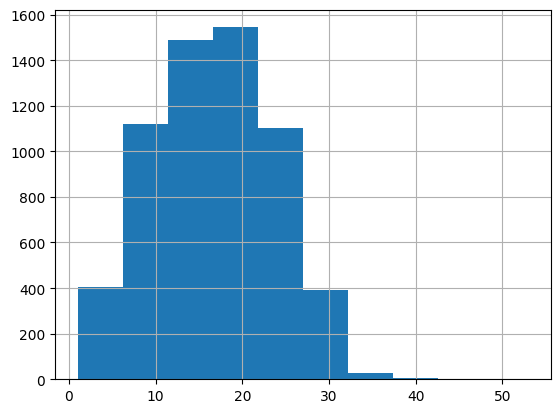

In [28]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()

In [29]:
def padding(sentences, seq_len, padding='right'):
    """
    Pads/truncates all sentences to the same length.

    Args:
        sentences (list of lists): List of tokenized sentences.
        seq_len (int): Desired sequence length.
        padding (str): 'right' for right-alignment, 'left' for left-alignment.

    Returns:
        np.array: 2D array with padded sequences.
    """
    # Initialize a 2D array of zeros (padded value).
    features = np.zeros((len(sentences), seq_len), dtype=int)

    for i, review in enumerate(sentences):
        review_len = len(review)
        
        if review_len == 0:
            continue

        if padding == 'right':
            # If sentence is longer than seq_len, truncate it
            features[i, -min(review_len, seq_len):] = np.array(review)[:seq_len]
        elif padding == 'left':
            # Left-align the sentence and pad with zeros at the end
            features[i, :min(review_len, seq_len)] = np.array(review)[:seq_len]

    return features

In [30]:
X_train = padding(X_train, 15)
X_dev = padding(X_dev, 15)

In [31]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_dev, y_dev = torch.Tensor(X_dev), torch.Tensor(y_dev)

In [32]:
train_dataset = TensorDataset(X_train, y_train)
dev_dataset = TensorDataset(X_dev, y_dev)

batch_size = 13

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, drop_last = True)

## Model Defintion

Using a Bi-LSTM model.

In [34]:
import torch
import torch.nn as nn

class TweetClassifier(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, num_layers, kernels, num_filters):
        super(TweetClassifier, self).__init__()
        
        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer for LSTM output
        self.lstm_fc = nn.Linear(hidden_dim, hidden_dim)  # Ensure this matches the hidden_dim
        
        # CNN layers
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in kernels
        ])
        
        # Calculate the total number of features after concatenation
        total_features = hidden_dim + len(kernels) * num_filters
        
        # Fully connected layer for combined output
        self.fc = nn.Linear(total_features, output_size)
        
    def forward(self, text):
        # Embedding lookups
        text_embeds = self.embedding(text)
        
        # LSTM Processing
        lstm_out, (hn, _) = self.lstm(text_embeds)
        lstm_out = self.lstm_fc(hn[-1])  # Use the last hidden state
        
        # Add channel dimension for CNN input
        text_embeds = text_embeds.unsqueeze(1)
        
        # CNN Processing
        conv_outs = [torch.relu(conv(text_embeds)).squeeze(3) for conv in self.convs]
        pooled_outs = [torch.max(out, dim=2)[0] for out in conv_outs]
        
        # Concatenate LSTM output and CNN outputs
        combined_out = torch.cat([lstm_out] + pooled_outs, dim=1)
        
        # Final fully connected layer
        out = self.fc(combined_out)
        
        return out


## Train

#### Utility functions

In [44]:
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# General Params
add_lr_scheduler = True
output_size = 1
batch_size = 512
n_epochs = 100
clip = 5

# Embedding params
num_words = 100
embedding_dim = 728

# CNN Params
kernels = (2, 3, 4, 5)
num_filters = 8  # 8 ==> 16

# LSTM Params
hidden_dim = 256
num_layers = 2

# Model
model = TweetClassifier(
    output_size=output_size,
    vocab_size=len(vocab) - 1,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    kernels=kernels,
    num_filters=num_filters,
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()  # Assuming binary classification

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

trainAcc = []
trainLoss = []
devAcc = []
devLoss = []
    
yTrue, yPred = [], []

for epochi in tqdm(range(n_epochs)):
        batchAcc = []
        batchLoss = []

        model.train()

        for X, y in train_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            yhat = model(X)
            yhat = yhat.squeeze()
            loss = criterion(yhat, y)

            batchAcc.append(100*torch.mean(((yhat.cpu() > .0) == y.cpu()).float()))
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
        
            optimizer.step()

            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))

        model.eval()
        
        with torch.no_grad():
        
            batchAcc = []
            batchLoss = []

            for X, y in dev_dataloader:
                X, y = X.to(device, dtype=torch.int), y.to(device)
                yHat = model(X)
                yHat = yHat.squeeze()
                loss = criterion(yhat, y)
                
                yPred.extend(yHat.cpu() > .0)
                yTrue.extend(y.cpu())

                batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
                batchLoss.append(loss.item())

            devAcc.append(np.mean(batchAcc))
            devLoss.append(np.mean(batchLoss))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:53<00:00,  5.33s/it]


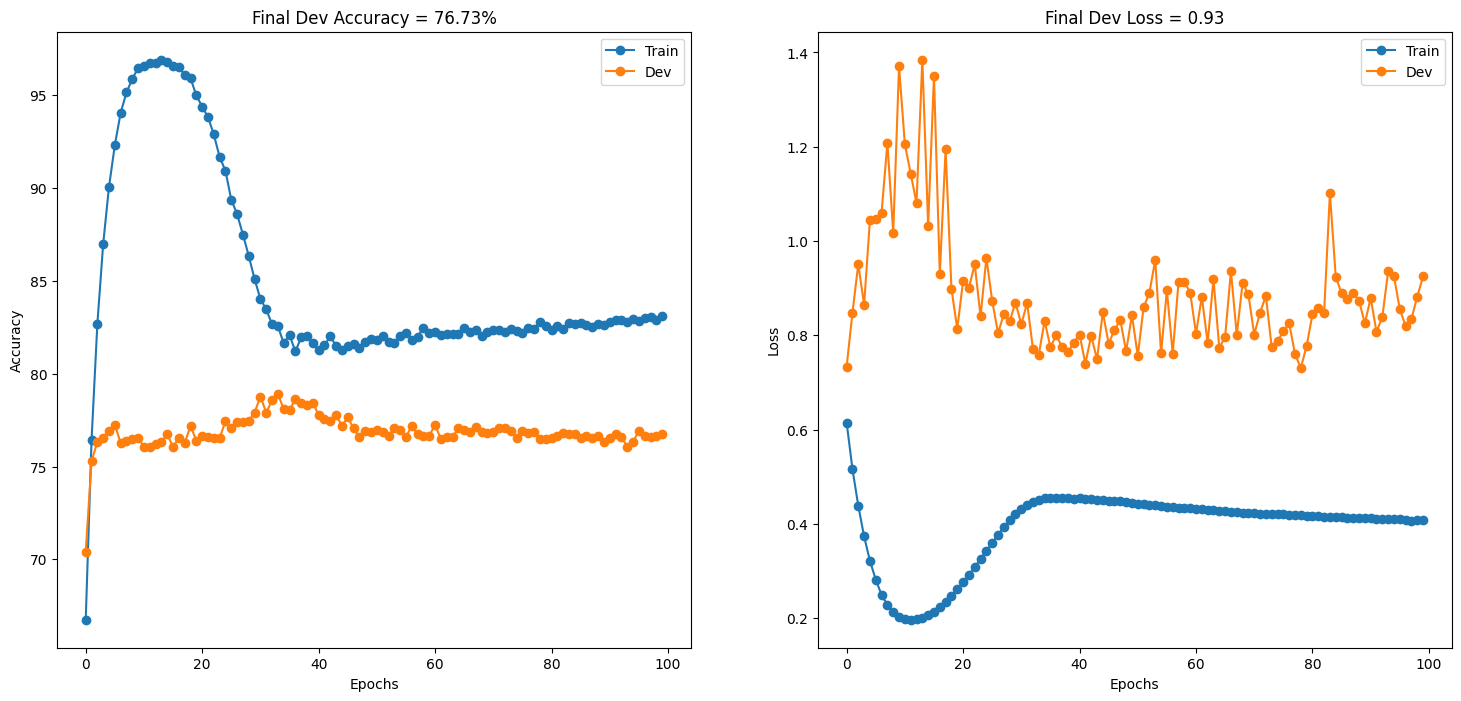

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(devAcc, 'o-', label = 'Dev')
ax[0].set_title(f'Final Dev Accuracy = {devAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(devLoss, 'o-', label = 'Dev')
ax[1].set_title(f'Final Dev Loss = {devLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

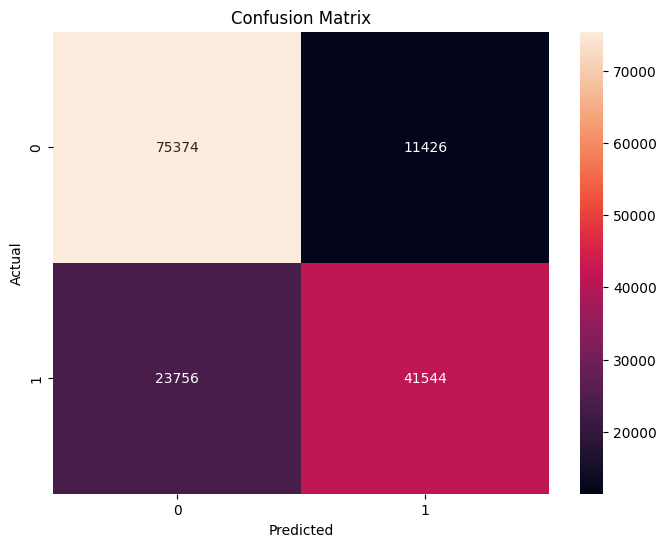

In [51]:
cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
precision = precision_score(yTrue, yPred)
recall = recall_score(yTrue, yPred)
f1Score = f1_score(yTrue, yPred)

In [55]:
html_code = f"""
    <div style="display: flex; flex-direction: row; justify-content: center; align-items: center; gap: 30px">
        <span>
            <h3 style="line-height: 30px; background-color: #cc3d76; padding: 20px 20px; border-radius: 8px">Precision {precision:.2f}</h3>
        </span>
        
        <span>
            <h3 style="line-height: 30px; background-color: #b3245d; padding: 20px 20px; border-radius: 8px">Recall {recall:.2f}</h3>
        </span>
        
        <span>
            <h3 style="line-height: 30px; background-color: #d40457; padding: 20px 20px; border-radius: 8px">F1-Score {f1Score:.2f}</h3>
        </span>
    </div>
"""
HTML(html_code)